In [110]:
import torch, einops, pathlib, cv2, json
import numpy as np
import matplotlib.pylab as plt
from matplotlib import patches
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn.models import GCN


class FallDetector(nn.Module):

    def __init__(self, feature_dim=32):
        super(FallDetector, self).__init__()

        self.feature_extractor = GCN(2, feature_dim, num_layers=2, act="leaky_relu", norm="LayerNorm")
        self.detector = nn.LSTM(feature_dim, feature_dim, 1, batch_first=True)
        self.classifier = nn.Linear(feature_dim, 1)

    def forward(self, frames, edge):
        N, L, M, _ = frames.shape

        frames = einops.rearrange(frames, "n l m d -> (n l m) d")
        edge = torch.cat([edge + M*i for i in range(N*L)], dim=-1)

        print(frames.shape, edge.shape)
        
        x = self.feature_extractor(frames, edge)
        x = einops.rearrange(x, "(n l m) d -> n l m d", n=N, l=L).mean(dim=2)
        x, (hn, cn) = self.detector(x)
        x = self.classifier(x[:, -1])
        return x

In [5]:
gcn = GCN(2, 32, num_layers=2, act="leaky_relu", norm="LayerNorm")

In [38]:
x = torch.randn(10, 2)

In [13]:
edge = torch.tensor([
    [0, 2, 4, 6, 8],
    [1, 3, 5, 7, 9],
])

In [47]:
out = gcn(x, edge)
out.shape

torch.Size([10, 15, 10, 32])

In [54]:
model = FallDetector()

In [55]:
x = torch.randn(10, 15, 10, 2)
model(x, edge)

torch.Size([1500, 2]) torch.Size([2, 750])


tensor([[0.0917],
        [0.0948],
        [0.1277],
        [0.1184],
        [0.1411],
        [0.1316],
        [0.1565],
        [0.1336],
        [0.1440],
        [0.1123]], grad_fn=<AddmmBackward0>)

In [107]:
class URDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.data_list = self._load_data_list()

    def _load_data_list(self):
        data_list = []
        for path in pathlib.Path(self.data_dir).glob("*/*.json"):
            data_list.append((path, int("fall" in path.name)))

        return data_list
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        path, fallen = self.data_list[index]
        print(path)
        frames, valid_frame_index = self.read_keypoints(path)
        frames = self.interpolate(frames, valid_frame_index)
        return frames, fallen
    
    def interpolate(self, keypoints, valid_frame_index):
        start_index = 0
        while valid_frame_index[start_index] == 0:
            start_index += 1

        end_index = len(keypoints) - 1
        while valid_frame_index[end_index] == 0:
            end_index -= 1

        keypoints = keypoints[start_index:end_index]
        valid_frame_index = valid_frame_index[start_index:end_index]

        for i in range(1, len(keypoints) - 1):
            if valid_frame_index[i] == 0:
                prev_kpts = keypoints[i - 1]
                next_kpts_index = i + 1
                while valid_frame_index[next_kpts_index] == 0:
                    next_kpts_index += 1
                next_kpts = keypoints[next_kpts_index]
                curr_kpts = prev_kpts * ((next_kpts_index - i)/(next_kpts_index - i + 1)) + next_kpts * (1/(next_kpts_index - i + 1))
                keypoints[i] = curr_kpts

        return keypoints
    
    def read_keypoints(self, path):
        with open(str(path)) as f:
            data = json.load(f)
        
        keypoints = data["keypoints"]
        keypoints = torch.stack([torch.tensor(list(kpts.values())[0]) if len(kpts.values()) > 0 else torch.zeros(17, 3) for kpts in keypoints])
        valid_frame_index = torch.tensor([1 if len(data["keypoints"][i].values()) > 0 else 0 for i in range(len(keypoints))])
        return keypoints, valid_frame_index

In [108]:
dataset = URDataset("../easy_ViTPose/output/")
len(dataset)

70

In [109]:
frames = dataset[0][0]
frames.shape

../easy_ViTPose/output/parsed_adl-37-cam0.mp4/parsed_adl-37-cam0_result.json


torch.Size([247, 17, 3])

tensor([65.3559, 60.7324,  0.8845])
tensor([62.8767, 61.2869,  0.9052])
tensor([63.2359, 58.3507,  0.8909])
tensor([63.8444, 62.2764,  0.7076])
tensor([64.5195, 54.0480,  0.8790])
tensor([75.7710, 64.1121,  0.8928])
tensor([76.7098, 51.2145,  0.8482])
tensor([90.5093, 66.7663,  0.8164])
tensor([92.3930, 50.7710,  0.7604])
tensor([102.7138,  67.4033,   0.8270])
tensor([104.1884,  57.7950,   0.6073])
tensor([105.2107,  64.1432,   0.8831])
tensor([105.9875,  54.3799,   0.7919])
tensor([127.4779,  69.8263,   0.8820])
tensor([128.6102,  53.4926,   0.8472])
tensor([144.9236,  76.1766,   0.8714])
tensor([146.6867,  52.6319,   0.8337])
tensor([65.7842, 61.3870,  0.8946])
tensor([63.2053, 62.0798,  0.8532])
tensor([63.6399, 58.8612,  0.8659])
tensor([64.2820, 63.4180,  0.7442])
tensor([64.9382, 54.8926,  0.8562])
tensor([76.6044, 65.3989,  0.8721])
tensor([77.6272, 52.0688,  0.8515])
tensor([91.2413, 68.3886,  0.8331])
tensor([93.2730, 51.6237,  0.7484])
tensor([103.7953,  69.0227,   0.8260])
t

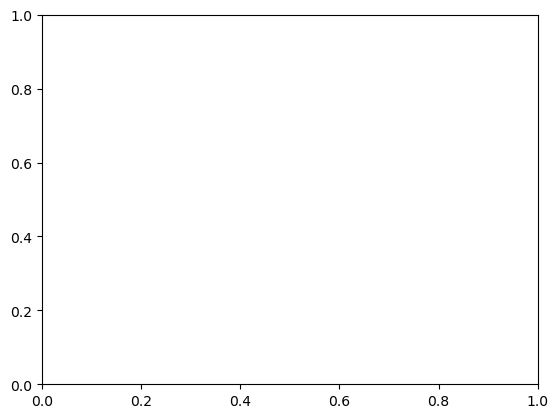

In [ ]:

fig, ax = plt.subplots(1, 10)
for i in range(0, 10):
    for kp in frame:
        c = patches.Circle((kp[0], kp[1]), radius=5, fill=True, color="red")
        ax[i].add_patch(c)

plt.show()

In [ ]:
EPOCHS = 10

dloader = DataLoader(dataset, batch_size=1, shuffle=True)

def training_step(x):
    for e in range(EPOCHS):
        for frames, labels in dloader:
            frames = frames.to(0)
            labels = labels.to(0)

            model(frames, )